# `mugatu` example: concentric circles

Let's start with a trivial example: a synthetic dataset of two noisy concentric circles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import sklearn.datasets
import dask
import panel as pn

%matplotlib inline

## Setup

`mugatu` uses the `dask` library to parallelize clustering. You can use `dask.config.set` to configure the default scheduler for your system.

In [2]:
import mugatu

In [3]:
dask.config.set(scheduler='processes')

## Prepare data

`mugatu` expects your data to come in a `pandas.DataFrame` object. The index of the DataFrame is used to relate nodes on the Mapper graph back to raw data points.

Each lens used to filter the data should be a 1D numpy array with the same length as the DataFrame.

In [4]:
data, _ = sklearn.datasets.make_circles(n_samples=5000, noise=0.05,
                                       factor=0.3, random_state=42)
df = pd.DataFrame({"x":data[:,0], "y":data[:,1]})

lens1 = df.x.values
lens2 = df.y.values

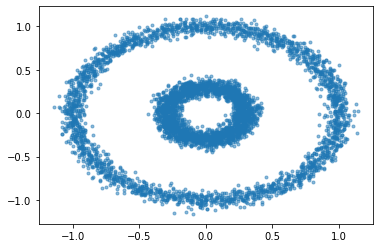

In [5]:
plt.plot(df.x, df.y, ".", alpha=0.5);

## Compute mapper graph

The `mugatu.build_mapper_graph()` function will take it from here. The parameters you choose will have a significant effect on your output:

* `lens`: `mugatu` can filter on one or two dimensions. If two, the bins are computed hierarchically (within each bin from the first dimension, `num_intervals` and `f` are applied on the second). This may differ from other Mapper implementations that use an overlapping hypercubic grid.
* `num_intervals` how many bins to filter each dimension into. If you're using two lenses and `num_intervals=5`, there will be 25 bins total.
* `f` by what fraction the bins should overlap
* `pca_dim` **within each bin**, use PCA to reduce the dimension to this value. This may differ from other implementations that are designed for global, but not local, dimension reduction. Set to 0 to skip the PCA step.
* `balance` will filter the data into bins of equal occupation rather than equal width.

The function outputs two things:

* `cluster_indices` is a list of arrays. The $i$th element of this list is an array of indices of all the original data points that were mapped to node $i$ in the Mapper graph.
* `g` is the Mapper graph itself, as a `networkx.Graph` object

In [6]:
num_intervals = 10
f = 0.5
pca_dim = 0
k = 3
balance = False

cluster_indices, g = mugatu.build_mapper_graph(df, lens1, lens2=lens2, num_intervals=num_intervals, 
                                               f=f, balance=balance, pca_dim=pca_dim, k=k)

We can visualize `g` with whatever generic graph viz tools we have laying around:

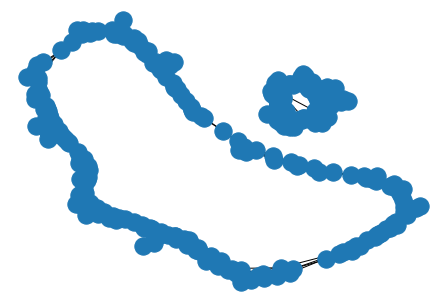

In [7]:
np.random.seed(1)
layout = nx.layout.fruchterman_reingold_layout(g, iterations=100)
nx.draw(g, pos=layout)

## Same thing, but now with a GUI

I generally think GUIs are overrated but in this case they can be helpful. Call `panel.extension()` to enable panel widgets in Jupyter, or follow the `panel` docs to serve it up as an app.

#### The Mapperator

This object is where the GUI lives.

* To initialize, pass `Mapperator` your data, a dictionary of any lenses you want to use, and a dictionary of any exogenous data you'd like to use to color the nodes in the Mapper graph.
* `Mapperator` will also precompute some generic lenses by default- the first and second singular vectors, an anomaly score based on an isolation forest, and an L2 distance from each column's mean.
* `Mapperator.panel()` will return the `panel` object containing the GUI
* The `panel` library has a habit of failing silently when something goes wrong- if your modeling mysteriously hangs and never finishes, try running `Mapperator.build_mapper_model()` to get a stack trace.

In [8]:
pn.extension()

Two finicky pieces of minutiae:

* `Mapperator` assumes you have more than two variables (the first and second singular vectors are used to help laying out the graph)- so for this example we'll just make a copy of one of them.
* The `holoviews.Dataset` object appears to have some protected column names. Don't use `x` or `y` for lens names.

In [9]:
df["z"] = df["x"].values

In [10]:
mapper = mugatu.Mapperator(df, lens_data={"lens_x":df.x.values, "lens_y":df.y.values})

In [11]:
mapper.panel()

Tabs
    [0] Column
        [0] Row
            [0] Column
                [0] Markdown(str)
                [1] CrossSelector(name='Inputs', options=['x', 'y', 'z'], value=['x', 'y', 'z'])
            [1] Column
                [0] Markdown(str)
                [1] Select(name='Lens 1', options=['lens_x', 'lens_y', ...], value='lens_x')
                [2] Select(name='Lens 2', options=['None', 'lens_x', ...], value='None')
        [1] Divider()
        [2] Column
            [0] Row
                [0] IntInput(name='PCA dimension (..., value=2)
                [1] IntInput(name='k', value=5)
                [2] Checkbox(name='Include indices i...)
            [1] Row
                [0] IntInput(name='Number of intervals', value=5)
                [1] FloatInput(name='Overlap fraction', value=0.25)
                [2] Checkbox(name='Balance intervals')
        [3] Divider()
        [4] Row
            [0] Button(button_type='success', name='PUNCH IT, CHEWIE')
            [1] Progress(active=False, value=100, width=600)
    [1] Column
        [0] Row
            [0] HoloViews(HoloMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='Default', options=['blue', 'red'], value='blue', width=250)
                [1] VSpacer()
        [1] FileDownload(callback=<function _build_widgets.<..., filename='mugatu.html', label='Download mugatu.html', name='Download figure (...)